In [2]:
# JSS
## TODO 
#using pca to reduce the dimensionality of the global descriptors
#using MobileVnet instead of netVLAD
#using hfnet instead of netVlAD and MobileVnet --that is not working 
# this will also help reduce the complexity 
#understand what superglue is outputting
# getting two models from SFM 
# Setting up the scale of the model -- this is done easy and simple
import numpy as np
import argparse
import yaml
import logging
from pathlib import Path
from tqdm import tqdm
from pprint import pformat
import h5py
import json
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from shutil import copyfile
# from notebooks.utils import plot_images, plot_matches, add_frame
from hfnet.models import get_model  

In [17]:
# send the path to the image directory and get the path to all the images in it
def image_directory_parser(path, viewer=True, number= 4):    
    globs=['*.jpg', '*.png', '*.jpeg', '*.JPG', '*.PNG']
    ## can also use sufix instead of with method
    image_path = []
    for g in globs:
        image_path += list(path.glob("**/"+g))
    print(len(image_path))
    if viewer:
        nrows = number
        ncols = number
        fig = plt.gcf()
        fig.set_size_inches(ncols*4, ncols*4)
        for i in range(2*number):
            sp = plt.subplot(nrows, ncols, i + 1)
            sp.axis('Off') # Don't show axes (or gridlines)
            img = mpimg.imread((image_path[i]))
            plt.imshow(img)
        plt.show()
    return image_path

In [18]:
## JSON parser
def Trajectory5(path_to_json, skip=0):
	useful_filenames = path_to_json/"useful_filenames.json"
	useful_tvecs = path_to_json/"useful_tvecs.json"
	useful_rvecs = path_to_json/"useful_rvecs.json"
	with open(useful_rvecs) as f:
		rvecs = json.load(f)
	with open(useful_tvecs) as f:
		tvecs = json.load(f)
	with open(useful_filenames) as f:
		usefull_filenames = json.load(f)
	current_skip = 0
	from_useful = {}
	for i in tqdm(range(len(usefull_filenames))):
		if current_skip<skip:
			current_skip+=1
			continue
		current_skip = 0
		from_useful[usefull_filenames[i]]= {"tvecs": tvecs[i], "rvecs": rvecs[i]}
	return from_useful

3338


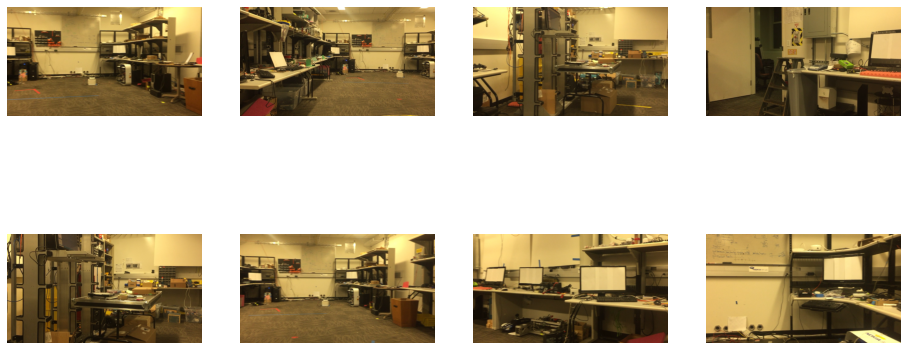

In [19]:
path_to_images_for_map = Path('/home/Hierarchical-Localization/datasets/Trajectory5/skip5')
image_path = image_directory_parser(path_to_images_for_map, viewer=True, number = 4) 


In [20]:
path_to_json = path_to_images_for_map = Path('/home/Hierarchical-Localization/datasets/Trajectory5/UsefulPosesT5GS2')

In [21]:
using = Trajectory5(path_to_json, skip=9) ## this dict will always be the same 

100%|██████████| 20031/20031 [00:00<00:00, 1726027.27it/s]


In [22]:
## This funciton is diffrent in trajectory 5 because of the skip parameter
# image dictionary creator gives image, its name and index as dictionary
# def dictionary_of_images(image_path, using, path_to_images_for_map):
#     list_of_image = list(using.keys())
#     image_dict ={}
#     to_save = (path_to_images_for_map.parent)/"skip9"
#     index = 0
#     for i,j in tqdm(enumerate(image_path)):
#         if str(j.name) in list_of_image:
#             image_array = cv2.imread(str(j))
#     #         print(image_path[i].name)
#             image_to_save = to_save/j.name
#             copyfile(j,image_to_save)
#             image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
#             image_dict[index] = {"image":image_array, "name": image_path[i].name, "number": index}
#             index+=1
#     return image_dict
# image dictionary creator gives image, its name and index as dictionary
def dictionary_of_images(image_path):
    image_dict ={}
    for i,j in tqdm(enumerate(image_path)):
        image_array = cv2.imread(str(j))
#         print(image_path[i].name)
        image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
        image_dict[i] = {"image":image_array, "name": image_path[i].name, "number": i}
    return image_dict


In [25]:
image_dict = dictionary_of_images(image_path)
print(len(image_dict))


3338it [00:29, 112.13it/s]

3338


In [26]:
## assigning the new image directory to 

In [27]:
# this finds the global matrix and 
def global_dict_matrix_and_H5_map(config, image_dict):
    predictions_dict = {}
    global_feature_path = (config["output"])/"global_features.h5"
    global_feature_file = h5py.File(str(global_feature_path), 'w')
    checkpoint_path = Path(config["checkpoint_path"])
    keys = ['global_descriptor']    
    with get_model(config['model']['name'])(
            data_shape={'image': [None, None, None, 3]},
            **config['model']) as net:
        if checkpoint_path is not None:
            net.load(str(checkpoint_path))
        for i in tqdm(range(len(image_dict))):
            data = image_dict[i] ## selecting using index
            predictions = net.predict(data, keys=keys)
            predictions_dict[i] = {"global_descriptor":predictions['global_descriptor'], "name" : data['name']}   
            if i == 0:
                global_matrix = np.array(predictions['global_descriptor'])
            else:
                global_matrix = np.vstack((global_matrix,predictions['global_descriptor']))
            grp = global_feature_file.create_group(data['name'])
            grp.create_dataset('global_descriptor', data=predictions['global_descriptor'])
        global_feature_file.close()
    return predictions_dict, global_matrix
def compute_distance(desc1, desc2):
    # For normalized descriptors, computing the distance is a simple matrix multiplication.
    return 2 * (1 - desc1 @ desc2.T)
## needs both global matrix and dict as we need to give names too
## I am idiot if I keep wiritng codes like this one lol ;)
# Need to change it hehehe
# Writing the .txt file.
def text_file_for_global_matches(global_feature_dict, global_feature_matrix, path, number): 
    predictions_dict_matches = {}
    for i in tqdm(range(len(global_feature_dict))):
        current_descriptor = global_feature_matrix[i, :]
        neighbours = compute_distance(current_descriptor, global_feature_matrix)
        predictions_dict_matches[i] = ((np.argsort(neighbours))[:number])[1 :]
    #first writing the file
    output_file_txt = path/"global_feature.txt"
    with open(output_file_txt, 'w') as f:
        for i in tqdm(range(len(predictions_dict_matches))):
            current_image_name = global_feature_dict[i]["name"]
            current_image_matches = predictions_dict_matches[i]
            string_list = []
            for j in range(len(current_image_matches)):
                    if i == 0 and j ==0:
                        making_a_string = current_image_name + " " + global_feature_dict[current_image_matches[j]]["name"]
                    
                    else: 
                        making_a_string = "\n" + current_image_name + " " + global_feature_dict[current_image_matches[j]]["name"]
                    f.write(making_a_string)  
    ## checking common lines and rewriting
    image_list_for_finding_common_separated = []
    with open(output_file_txt, 'r') as f:
        image_list_for_finding_common = [l.strip() for l in f]
    for i in range(len(image_list_for_finding_common)):
        current_index_value = image_list_for_finding_common[i]
        current_index_value = list(current_index_value.split(" "))
        image_list_for_finding_common_separated.append(sorted(current_index_value))
    ilf = sorted(image_list_for_finding_common_separated)
    final_list = []
    for i in range(len(ilf)):
        if ilf[i] in final_list:
            pass
        else:
            final_list.append(ilf[i])
    with open(output_file_txt, 'w') as f:
        for i in range(len(final_list)):
            if i == 0:
                making_a_string = final_list[i][0]+ " " + final_list[i][1]
            else:
                making_a_string = "\n" + final_list[i][0]+ " " + final_list[i][1]
            f.write(making_a_string)

In [7]:
output_path = Path("/home/Hierarchical-Localization/outputs/sfm_T5_skip_5")
# output_path.mkdir()
checkpoint_path = Path("/home/Hierarchical-Localization/weights/vd16_pitts30k_conv5_3_vlad_preL2_intra_white/vd16_pitts30k_conv5_3_vlad_preL2_intra_white")

In [29]:
config_global = {'output':output_path, 'checkpoint_path':checkpoint_path, 'data': {'name': 'aachen', 'load_db': False, 'load_queries': True, 'resize_max': 960}, 'model': {'name': 'netvlad_original', 'local_descriptor_layer': 'conv3_3', 'image_channels': 1}, 'weights': 'vd16_pitts30k_conv5_3_vlad_preL2_intra_white/vd16_pitts30k_conv5_3_vlad_preL2_intra_white'}         
global_dict_map, global_matrix = global_dict_matrix_and_H5_map(config_global, image_dict)

W0216 19:10:58.785850 140354349901632 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:104: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0216 19:10:58.803460 140354349901632 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:124: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0216 19:10:58.804520 140354349901632 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:124: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0216 19:10:58.805547 140354349901632 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/hfnet/models/base_model.py:275: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0216 19:10:58.808394 140354349901632 deprecation_wrapper.py:119] From /home/Hierarchical-Localization/h

In [30]:
text_file_for_global_matches(global_dict_map, global_matrix,output_path,5)

100%|██████████| 3338/3338 [00:00<00:00, 113123.26it/s]


In [3]:
### Bringing in HLOC
%load_ext autoreload
%autoreload 2
from hloc import extract_features, match_features, reconstruction, visualization
path_to_images_for_map = Path('/home/Hierarchical-Localization/datasets/Trajectory5/skip5')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
feature_conf_superpoint = {'output': 'features_superpoint', 'model': {'name': 'superpoint', 'nms_radius': 3, 'max_keypoints': 4096}, 'preprocessing': {'grayscale': True, 'resize_max': 960}}
# extract_features.main(feature_conf_superpoint,path_to_images_for_map,output_path)

In [ ]:
matcher_conf = {'output': 'matches-superglue', 'model': {'name': 'superglue', 'weights': 'outdoor', 'sinkhorn_iterations': 50}}
features = feature_conf_superpoint['output']
sfm_pairs = output_path/"global_feature.txt"
# match_features.main(matcher_conf, sfm_pairs, features, output_path)
sfm_dir = output_path/'sfm_superpoint+superglue'
feature_file = output_path/'features_superpoint.h5'
match_file = output_path/'features_superpoint_matches-superglue_global_feature.h5'
## check why the name given above is coming and change it 
reconstruction.main(
    sfm_dir,
    path_to_images_for_map,
    sfm_pairs,
    feature_file,
    match_file)

[02/18/2021 10:24:16 INFO] Creating an empty database...
[02/18/2021 10:24:17 INFO] Importing images into the database...
[02/18/2021 10:24:45 INFO] Importing features into the database...


100%|██████████| 3338/3338 [00:01<00:00, 2400.39it/s]


[02/18/2021 10:24:47 INFO] Importing matches into the database...


100%|██████████| 8001/8001 [00:03<00:00, 2070.39it/s]


[02/18/2021 10:24:51 INFO] Performing geometric verification of the matches...
[02/18/2021 10:24:54 INFO] Running the 3D reconstruction...
[02/18/2021 10:24:54 INFO] colmap mapper --database_path /home/Hierarchical-Localization/outputs/sfm_T5_skip_5/sfm_superpoint+superglue/database.db --image_path /home/Hierarchical-Localization/datasets/Trajectory5/skip5 --output_path /home/Hierarchical-Localization/outputs/sfm_T5_skip_5/sfm_superpoint+superglue/models


In [ ]:
print("k")